## Imports

In [4]:
# <!-- collapse=True -->
import gensim
%pylab inline


import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy
import pandas as pd
import itertools
import os
import codecs
import json
import sklearn


Populating the interactive namespace from numpy and matplotlib


# Load model

In [124]:
model = gensim.models.doc2vec.Doc2Vec.load("./doc2vec_model_20_02_2016.model")

## Extract the vector matrix only for the page level labels for the TNSE visualisation

In [ ]:
indexes, new_labels = zip(*[(i, label) for i,label in enumerate(model.docvecs.index2doctag)\
                            if "Post_ID" not in label])
X = X[indexes, :]

# Run TNSE analysis

In [9]:
from sklearn import manifold

n_neighbors  = 10
n_components = 2
tsne = manifold.TSNE(n_components=n_components, init='pca', verbose = 2, n_iter  = 3000, perplexity = 10, learning_rate  = 20)
Y = tsne.fit_transform(X)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 187 / 187
[t-SNE] Mean sigma: 0.461897
[t-SNE] Iteration 25: error = 1.3166066, gradient norm = 0.0205047
[t-SNE] Iteration 50: error = 1.2551972, gradient norm = 0.0177305
[t-SNE] Iteration 75: error = 1.0374932, gradient norm = 0.0097322
[t-SNE] Iteration 100: error = 0.9948145, gradient norm = 0.0086087
[t-SNE] Error after 100 iterations with early exaggeration: 0.994814
[t-SNE] Iteration 125: error = 0.9282401, gradient norm = 0.0062599
[t-SNE] Iteration 150: error = 0.9099764, gradient norm = 0.0057797
[t-SNE] Iteration 175: error = 0.9055398, gradient norm = 0.0056663
[t-SNE] Iteration 200: error = 0.9044295, gradient norm = 0.0056486
[t-SNE] Iteration 225: error = 0.9040895, gradient norm = 0.0056429
[t-SNE] Iteration 250: error = 0.9041076, gradient norm = 0.0056498
[t-SNE] Iteration 275: error = 0.9040835, gradient norm = 0.0056493
[t-SNE] Ite

# Plot the TSNE output. 
#### Publishers that are closely related should appear close to each other.
#### This is a nice method to visually display multi dimensional data (hundreds of dimensions) in 2d. 
#### Its a checksum for our results.
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Populating the interactive namespace from numpy and matplotlib


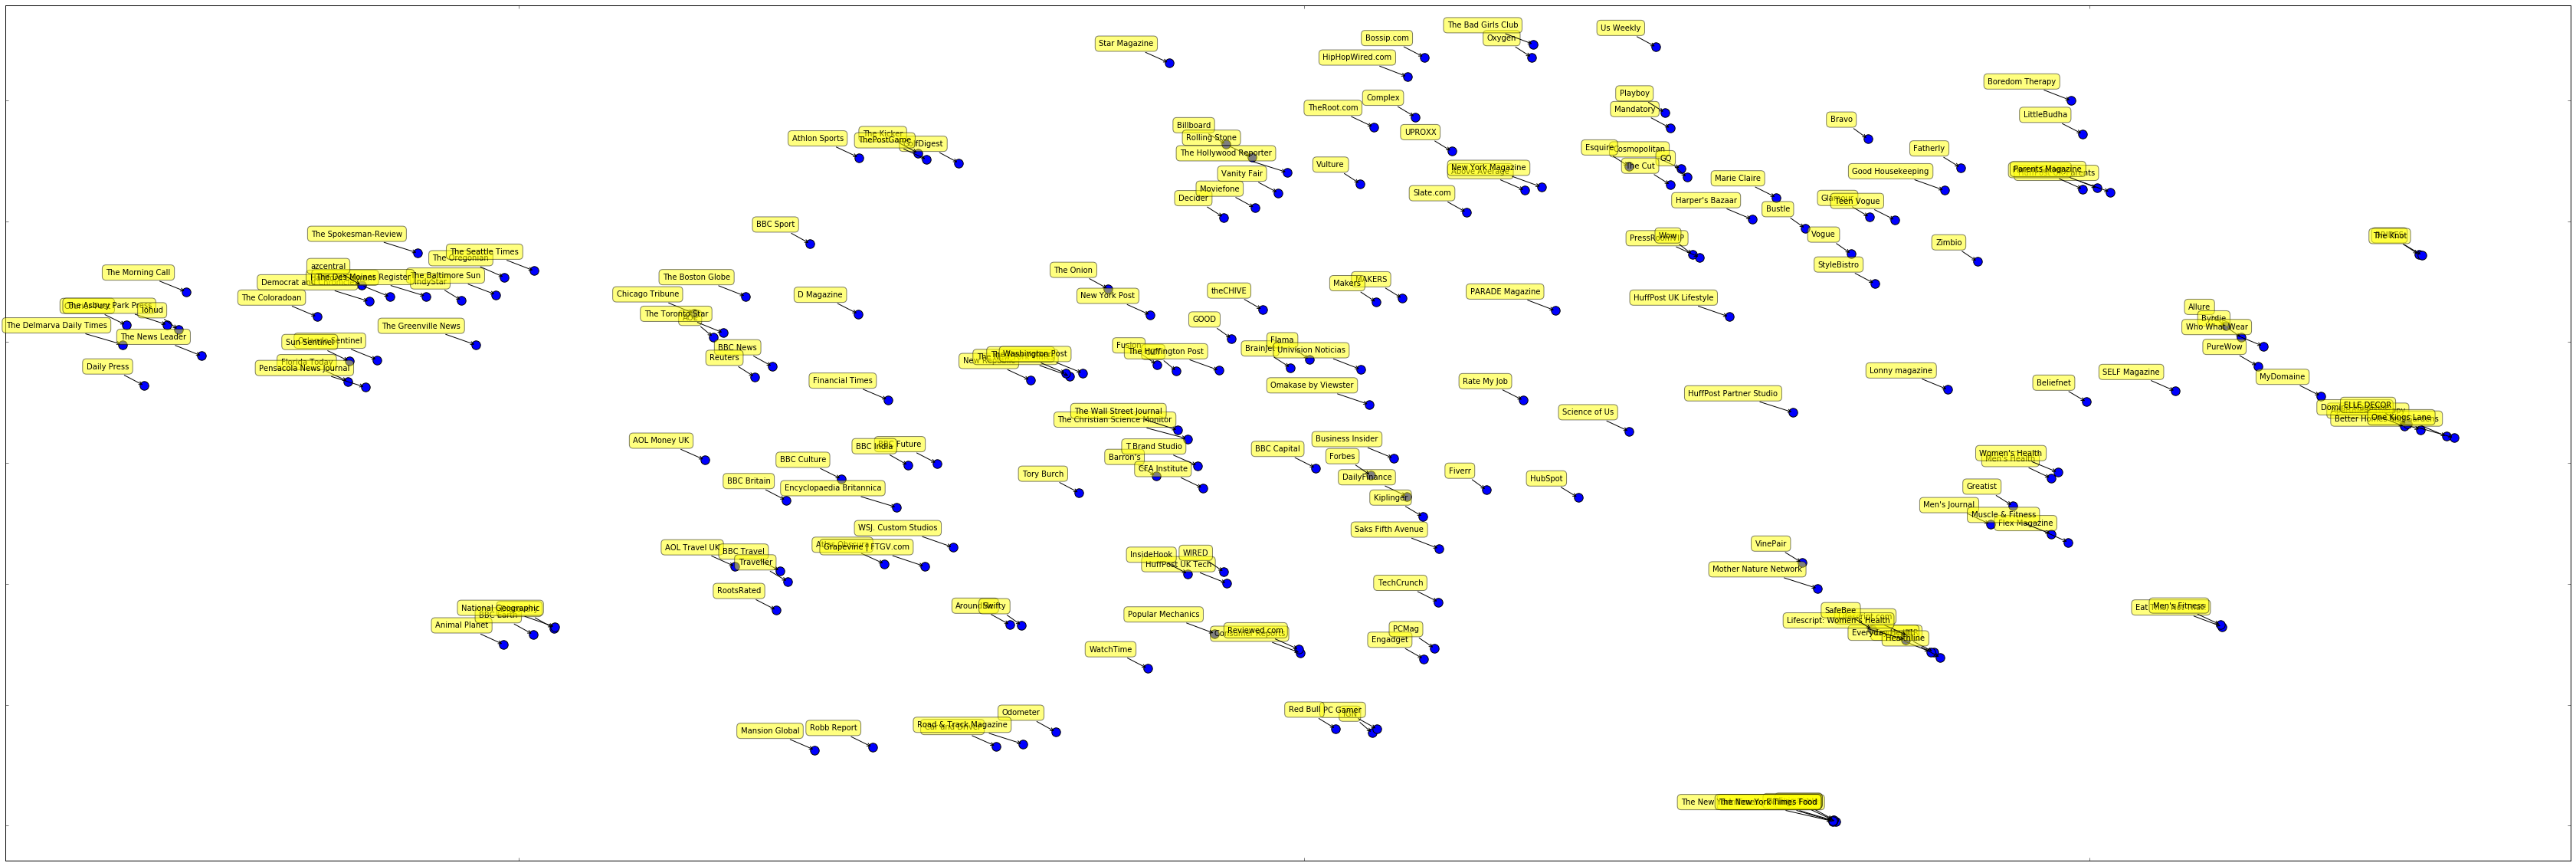

In [11]:
fig = plt.figure(figsize=(60, 20))
ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], s = 130, cmap=plt.cm.Spectral)
data = Y[:, :]

handled_labels = set([])
for label, x, y in zip(new_labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [ ]:
df = pd.read_hdf("./posts.hdf", key = "posts")

for group in df.groupby("page_name"):
    t = group[1].sort("shares", ascending = False)
    t["share_rank"] = scipy.stats.rankdata(t.shares.values) / float(len(t))
    t["shares_rank_bin"] = t.apply(lambda row: int(row["shares_rank"] * 100.0 / 10) * 10.0 / 100.0, axis = 1)        
    rows = t.to_dict(outtype = 'records')
    all_rows.extend(rows)
        
df = pd.DataFrame(all_rows)

#### Creating gensims documents iterator
A very important element is the order of the documents as they are presented to the neural network. 
Our iterator makes sure that we sample from all pages and all percentiles for each interval.

In [ ]:
                       
class MultiLabeledDocuments(object):
    def __init__(self, df):
        self.df = df
        groups = self.df.groupby(["shares_rank_bin"])
        training_rows = []
        final_groups = []
        
        for group in sorted(groups, key = lambda k: k[0])[::-1]:
            t = pd.DataFrame(group[1]).sort("shares_rank_bin", ascending = False)
            for page_group in t.groupby("page_name"):
                records = page_group[1].to_dict(outtype = 'records')
                final_groups.append(records)

        for chunk in xrange(0, 10000, 3):
            for group in final_groups:
                if len(group) > chunk:
                    fragment = group[chunk:chunk + 3]
                    training_rows.extend(fragment)
         
        self.rows_data = training_rows
        
    def __iter__(self):
        rows_data = self.rows_data
        
        chunk = []
        for row in rows_data:
            # The content field is the text we retreived from the post link 
            words = row["content"].split(" ")
            tags = ["%s_%s" % (row["page_name"], row["shares_rank_bin"] * 100.0), "Post_ID:%s" % row["post_id"]]
            return TaggedDocument(words = tokens, tags = tags)

            

            
 
     

#### Finally perform the training
We do a constant alpha training and lower it manually after each epoch

In [ ]:
docs = LabeledRowSentences(df)
model = doc2vec.Doc2Vec(alpha=0.05, min_alpha=0.05, min_count = 5, window = 17, dm = 1, negative = 0, workers = 4)  # use fixed learning rate
model.build_vocab(docs)

for epoch in xrange(50):
    print "Epoch: %s, alpha: %s" % (epoch, model_doc.alpha)
    model.train(docs)
    model.alpha = model_doc.alpha / 1.05 # decrease the learning rate
    model.min_alpha = model_doc.alpha  # fix the learning rate, no decay
